In [37]:
import pandas as pd
import re, ast
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
DATASET_FILE_PATH = "australian_user_reviews.json"

## Data Loading

In [6]:
def parse_steam_date(date_str):
    date_str = date_str.replace("Posted ", "").replace(".", "")
    
    if re.search(r'\d{4}$', date_str):
        fmt = "%B %d, %Y"
    else:
        date_str += ", 2016" 
        fmt = "%B %d, %Y"
        
    try:
        return datetime.strptime(date_str, fmt)
    except ValueError:
        return None 

In [7]:
def parse_helpful(helpful_str):
    if "No ratings yet" in helpful_str:
        return 0.0
    
    match = re.search(r'(\d+) of (\d+)', helpful_str)
    if match:
        numerator = int(match.group(1))
        denominator = int(match.group(2))
        if denominator == 0: return 0.0
        return numerator / denominator
    return 0.0

In [8]:
with open(DATASET_FILE_PATH, 'r', encoding='utf-8') as f:
    data = [ast.literal_eval(line) for line in f]

## Data processing
Removing all the entries without a properly formed date to avoid issues with not properly forming validation and test sets later on. 

In [9]:
rows = []
for user in data:
    user_id = user['user_id']
    for review in user['reviews']:
        rows.append({
            'user_id': user_id,
            'item_id': review['item_id'],
            'recommend': 1 if review['recommend'] else 0,
            'date': parse_steam_date(review['posted']),
            'helpful_score': parse_helpful(review['helpful']),
            'review_text': review['review'] 
        })

In [10]:
df = pd.DataFrame(rows)
df = df.dropna(subset=['date'])
df = df.sort_values(by='date')

print(f"Total interactions: {len(df)}")
df.head()

Total interactions: 59305


,user_id,item_id,recommend,date,helpful_score,review_text
20764,TheWhipster,39690,1,2010-10-16,0.400000,You'll Be Emo'd by the end of it!
29168,eddy96,40700,1,2010-10-25,0.000000,A very addictive puzzle game with incredible a...
29807,farsel,24010,1,2010-11-19,0.416667,this is the most epic of epics and these train...
29804,farsel,25700,1,2010-11-20,0.714286,"im mad about balls, and this game"
29801,farsel,15320,1,2010-11-20,0.888889,brill plane simulator where you can do some si...


## Data analysis

In [15]:
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_interactions = len(df)

matrix_size = n_users * n_items
sparsity = (1 - (n_interactions / matrix_size)) * 100

print(f"--- DATASET STATISTICS ---")
print(f"Number of Users: {n_users}")
print(f"Number of Items (Games): {n_items}")
print(f"Total Interactions (Reviews): {n_interactions}")
print(f"Sparsity: {sparsity:.4f}%")
print(f"Date Range: {df['date'].min().date()} to {df['date'].max().date()}")

--- DATASET STATISTICS ---
Number of Users: 25458
Number of Items (Games): 3682
Total Interactions (Reviews): 59305
Sparsity: 99.9367%
Date Range: 2010-10-16 to 2016-09-18


The matrix is extremely sparse. This means standard correlation methods might not work very well. We might need dimensionality reduction techniques like Matrix Factorization.

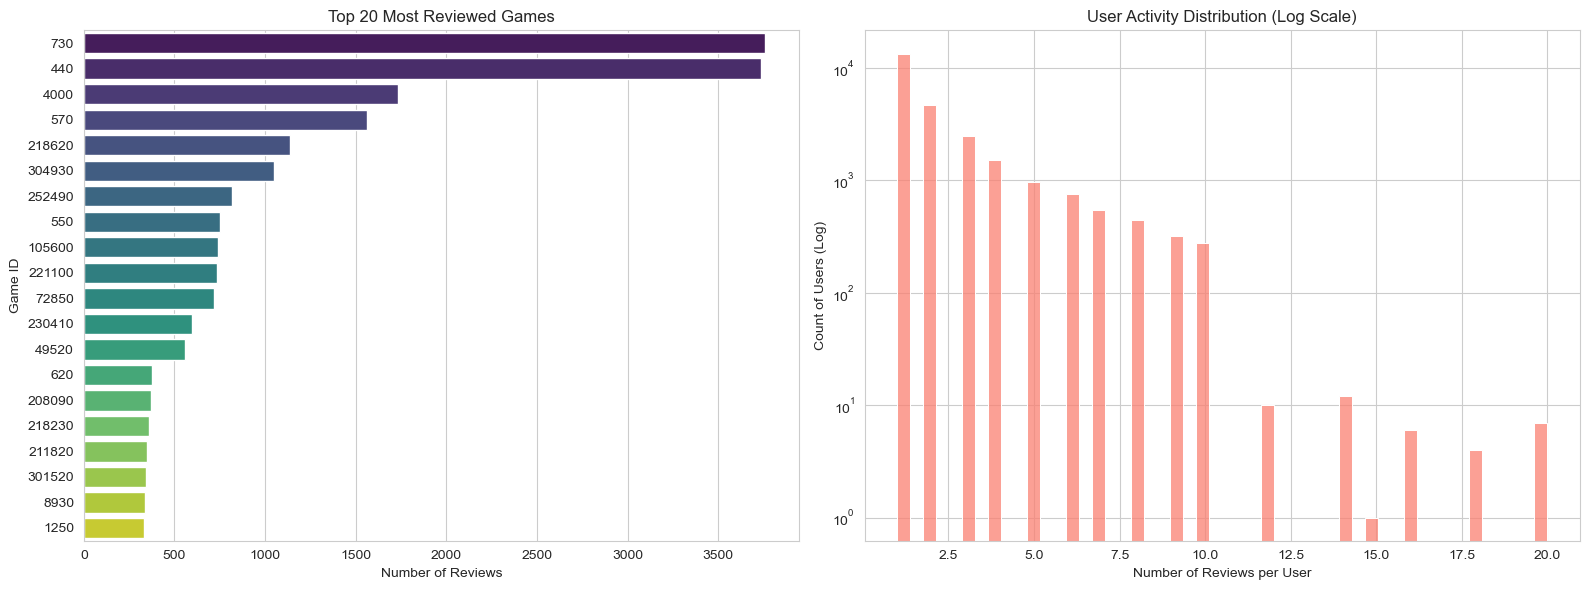

In [42]:
sns.set_style("whitegrid")
user_activity = df.groupby('user_id').size()
item_popularity = df.groupby('item_id').size()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

top_items = item_popularity.sort_values(ascending=False).head(20)
sns.barplot(x=top_items.values, y=top_items.index.astype(str), ax=ax[0], palette="viridis", hue=top_items.index.astype(str), legend=False)
ax[0].set_title("Top 20 Most Reviewed Games")
ax[0].set_xlabel("Number of Reviews")
ax[0].set_ylabel("Game ID")

sns.histplot(user_activity, bins=50, ax=ax[1], kde=False, color="salmon")
ax[1].set_yscale('log') # Log scale is here because of the huge variance
ax[1].set_title("User Activity Distribution (Log Scale)")
ax[1].set_xlabel("Number of Reviews per User")
ax[1].set_ylabel("Count of Users (Log)")

plt.tight_layout()
plt.show()

The data is highly skewed. A simple 'Most Popular' baseline will likely be very hard to beat because most users just play the popular games.

In [19]:
cold_start_users = (user_activity < 5).sum()
print(f"\n--- COLD START CHECK ---")
print(f"Users with < 5 reviews: {cold_start_users} ({cold_start_users/n_users:.1%} of total)")


--- COLD START CHECK ---
Users with < 5 reviews: 22124 (86.9% of total)


## Utility functions

In [24]:
def split_train_test(group):
    # If user has only 1 review, putting it in Test means we have 0 training data for them.
    # So we put it in Train to help learn global popularity.
    if len(group) < 2:
        return pd.DataFrame({
            'user_id': group['user_id'],
            'item_id': group['item_id'],
            'recommend': group['recommend'],
            'set': 'train' 
        })
    
    # If user has > 1 reviews, the LAST one is Test, the rest are Train
    else:
        group = group.copy()
        group['set'] = 'train'
        # Mark the very last interaction as 'test'
        group.iloc[-1, group.columns.get_loc('set')] = 'test'
        return group

In [26]:
df = df.sort_values(by=['user_id', 'date'])
df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)

train_df = df_split[df_split['set'] == 'train'].drop(columns=['set'])
test_df = df_split[df_split['set'] == 'test'].drop(columns=['set'])

print(f"Training Set Size: {len(train_df)} interactions")
print(f"Test Set Size:     {len(test_df)} interactions")
print(f"Users in Test Set: {test_df['user_id'].nunique()}")
print(f"Total Users:       {df['user_id'].nunique()}")

Training Set Size: 47242 interactions
Test Set Size:     12063 interactions
Users in Test Set: 12063
Total Users:       25458


/var/folders/v0/bskv74p54wg2s9fyrxpt1sc00000gn/T/ipykernel_82714/2723179381.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_split = df.groupby('user_id', group_keys=False).apply(split_train_test)


## Baseline model 
Find the top $k$ most popular games and predict those $k$ games for every user. 

To evaluate, check the list of games a user actually plays. If a game is in the list of recommended games count that as a hit, if not count that as a miss. 

In [20]:
def get_top_k_popular(train_df, k=10):
    item_counts = train_df['item_id'].value_counts()
    top_k_items = item_counts.head(k).index.tolist()
    return top_k_items

In [21]:
def evaluate_hit_ratio(test_df, recommended_items):
    hits = test_df['item_id'].isin(recommended_items)
    hit_ratio = hits.mean()
    return hit_ratio

In [32]:
K = 10
top_k_games = get_top_k_popular(train_df, k = K)
print(f"--- TOP {K} POPULAR GAMES (BASELINE) ---")
print(top_k_games)

popularity_score = evaluate_hit_ratio(test_df, top_k_games)
print(f"\n--- BASELINE RESULTS ---")
print(f"Hit Ratio @ {K}: {popularity_score:.4f}")
print(f"Meaning: The popularity model successfully predicted the user's next game {popularity_score*100:.2f}% of the time.")

--- TOP 10 POPULAR GAMES (BASELINE) ---
['440', '730', '4000', '570', '218620', '304930', '252490', '550', '105600', '221100']

--- BASELINE RESULTS ---
Hit Ratio @ 10: 0.1960
Meaning: The popularity model successfully predicted the user's next game 19.60% of the time.


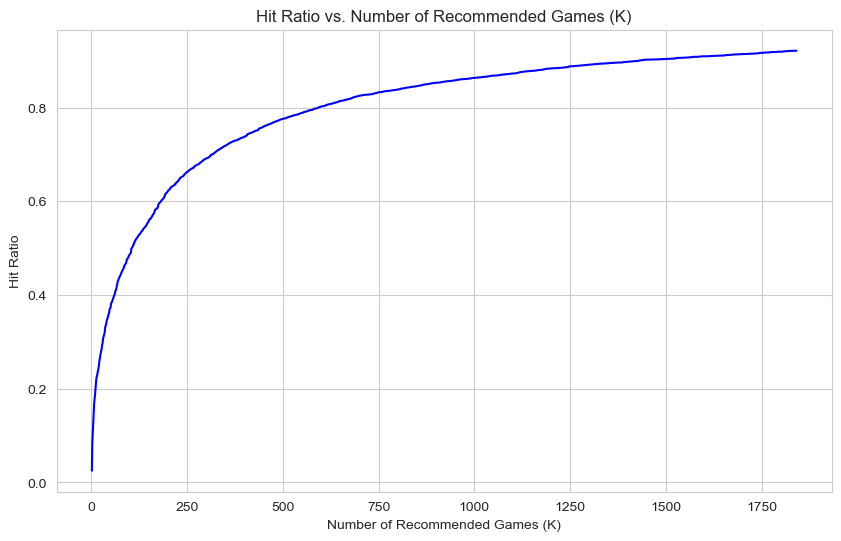

In [41]:
limit = 3682 // 2  # Half the number of unique items
popularity_scores = np.zeros(limit)
for k in range(1, limit + 1):
	top_k_games = get_top_k_popular(train_df, k = k)
	popularity_scores[k-1] = evaluate_hit_ratio(test_df, top_k_games)

plt.figure(figsize=(10, 6))
plt.plot(range(1, limit + 1), popularity_scores, color='blue')
plt.title("Hit Ratio vs. Number of Recommended Games (K)")
plt.xlabel("Number of Recommended Games (K)")
plt.ylabel("Hit Ratio")
plt.grid(True)
plt.show()